# Compare CB1r between HC and PTSD

In this notebook I am trying to see if 
1. there is a difference between PTSD and HC in the amount of CB1r availability in the Amygdala.
2. There is a correlation between CB1r in the Amygdala and PTSD symptoms 
 
## stages
1. load data
2. plot the data
3. check for normality

    3.1. calculate VIF
    
    3.2. plot correlation matrix
    
    
4. Statistics

* We are only interested in the Amygdala, analysis of different regions is only to asses global signals. hence, no correction for multiple comparisons will be conducted on regions.  

    4.1. T-test

    4.2. ANCOVA
       
    4.3. Correlation

## 1. load data

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
hc_path = '/media/Data/Lab_Projects/CB1/neuroimaging/CB1_results/OMAR_scores/dcd/HC/*/batch_omar_doneon_*.csv'

db = pd.DataFrame()

for sub in glob(hc_path):
    temp = pd.read_csv(sub)
    temp = temp[temp['Parameter']== 'VT']
    subID = temp.PatientID[0]
    temp = temp[['ROI', 'Value']]
    temp = temp.rename(columns={'Value': subID})
    temp = temp.set_index('ROI')
    temp = temp.T
    db = db.append(temp)
    
db['group'] = 'HC'

In [3]:
PTSD = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/CB1_clinical_30_6_21.csv')
PTSD = PTSD.set_index('PetID')
PTSD = PTSD[PTSD['PTSD'] == 'Yes']

PTSD_bg = PTSD.iloc[:, 11:]
PTSD_bg['group'] = 'PTSD'

db = db.append(PTSD_bg)

In [4]:
age = pd.read_csv('/home/nachshon/Documents/CB1/PETdata/age.csv')
age = age.set_index('PatientID')
data = db.merge(age , left_index=True, right_index=True)

## 2. Plot the Data

Look at how the data in the different regions distribute between groups and ages

In [5]:
data_long = data.copy()
data_long['sub'] = data_long.index
data_long = pd.melt(data_long, id_vars=['sub', 'group', 'sex', 'age'], 
                    value_vars = ['amygdala', 'cerebellum', 'cingulum_ant', 
                                  'frontal', 'hippocampus', 'insula', 
                                  'occipital', 'parietal', 'temporal', 'thalamus'],
                    var_name = 'ROI',
                    value_name = 'Vt')

In [6]:
data[['group','sex','age']].groupby(['group','sex']).count()

age
group sex     
HC    f      7
      m     21
PTSD  f      7
      m      6

In [7]:
descriptive = data.groupby(['group'], as_index=False).agg(['mean','std'])
descriptive

amygdala             caudate           cerebellum            \
           mean       std      mean       std       mean       std   
group                                                                
HC     1.670772  0.271389  1.335068  0.283941   1.431735  0.219815   
PTSD   1.326723  0.280324  1.017467  0.232820   1.213141  0.202993   

      cingulum_ant           cingulum_post            ...   putamen            \
              mean       std          mean       std  ...      mean       std   
group                                                 ...                       
HC        1.674012  0.242289      1.292393  0.233846  ...  1.743506  0.284885   
PTSD      1.390725  0.253097      1.042364  0.210558  ...  1.418300  0.274088   

       temporal            thalamus           ventromedial_pfc            age  \
           mean       std      mean       std             mean std       mean   
group                                                                           
HC     1.568730  0.230795  1.203179  0.200458         1.625091 NaN  28.750000   
PTSD   1.290019  0.225422  0.985329  0.167097              NaN NaN  42.307692   

                  
             std  
group             
HC     10.644508  
PTSD   13.567023  

[2 rows x 30 columns]

In [8]:
ROIs = ['amygdala', 'cerebellum', 'cingulum_ant', 'frontal',
        'hippocampus', 'insula', 'occipital', 'parietal', 'temporal']

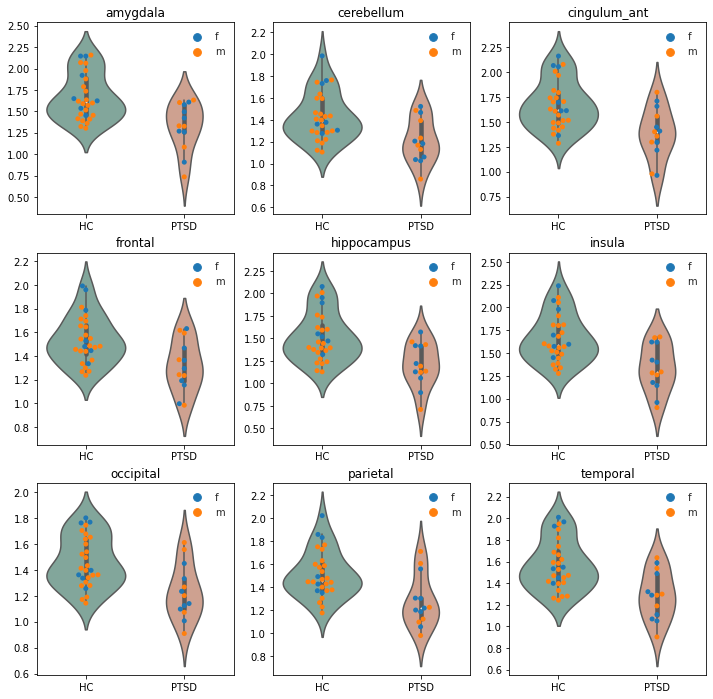

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
sns.set_style("whitegrid")

for i, ax in zip(range(10), axes.flat):
    roi = ROIs[i]
    sns.violinplot(x = 'group', y = 'Vt', data = data_long[data_long['ROI']==roi], ax=ax,
                   palette="Set2", scale="count", saturation = 0.4)
    
    sns.swarmplot(x = 'group', y = 'Vt', data = data_long[data_long['ROI']==roi],
                  ax=ax, hue="sex").set_title(roi)
    ax.set_ylabel('')    
    ax.set_xlabel('')
    ax.legend(frameon=False)


plt.show()


It looks like there is overall reduced levels of CB1r in PTSD compared with the HC.

No apparent sex differences, if there were, women seem to have higher levels, especially in the HC group.


Next we plot the age by Vt to look at how stable CB1r are with age.


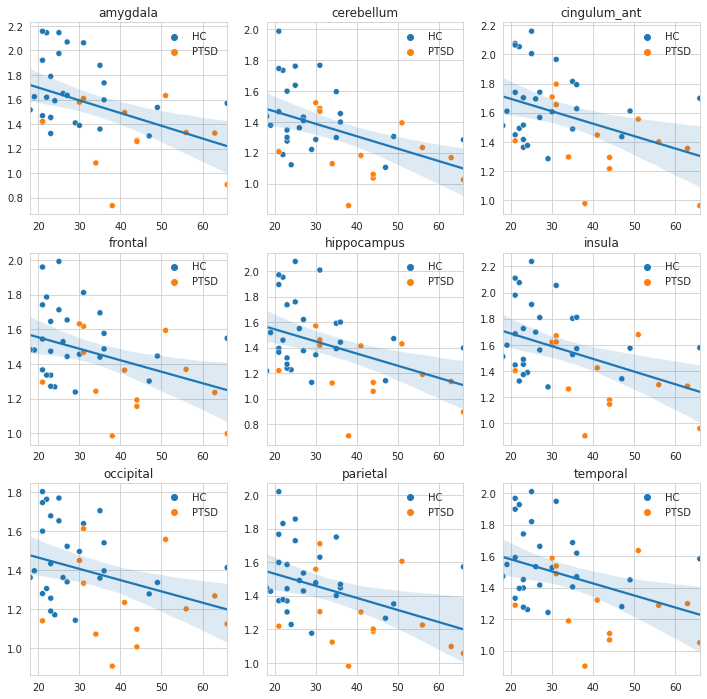

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
sns.set_style("whitegrid")

for i, ax in zip(range(10), axes.flat):
    roi = ROIs[i]
    
    sns.scatterplot(x = 'age', y = 'Vt', data = data_long[data_long['ROI']==roi],
                  hue = 'group', ax = ax).set_title(roi)
    
    sns.regplot(x = 'age', y = 'Vt', data = data_long[data_long['ROI']==roi], ax = ax, scatter=False)
    ax.legend(frameon=False)
    ax.set_ylabel('')    
    ax.set_xlabel('')

lines_labels = ax.get_legend_handles_labels()

plt.show()


It looks like there is a clear negative relation between age and CB1r availability.

Moreover, PTSD patients are older then the HC group.


## 3. check for normality

In [11]:
from scipy import stats

In [12]:
shapiro = pd.DataFrame()
for col in range(db.shape[-1]-1):
    temp = stats.shapiro(db.iloc[:,col])
    if temp.pvalue < 0.05:
        print(db.iloc[:,col].name)


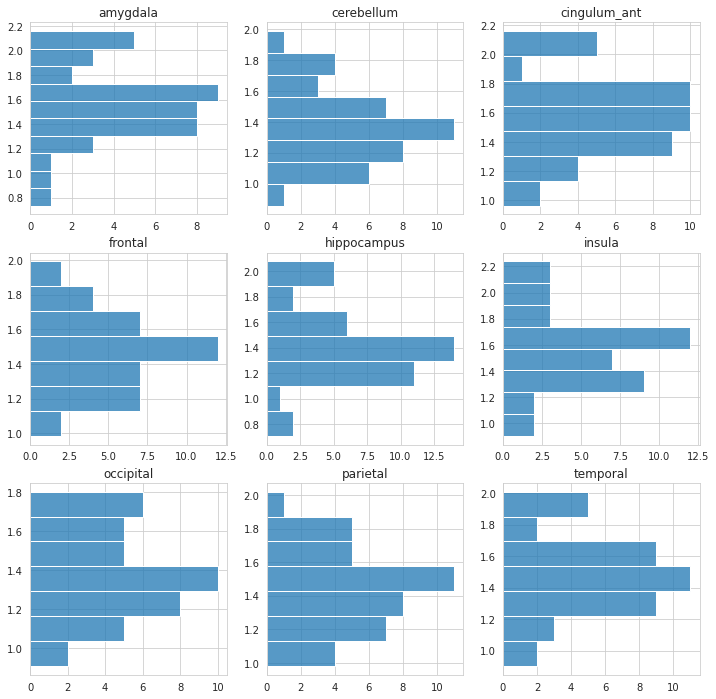

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
sns.set_style("whitegrid")

for i, ax in zip(range(10), axes.flat):
    roi = ROIs[i]
    
    sns.histplot(y = 'Vt', data = data_long[data_long['ROI']==roi],
                ax = ax).set_title(roi)
    
    ax.set_ylabel('')    
    ax.set_xlabel('')

plt.show()


Shapiro test of deviation from normality is not significant.
Visual inspection will disagree

### 3.1. calculate VIF

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data['sex'] = data['sex'].map({'m':1, 'f':0})
data['group'] = data['group'].map({'PTSD':1, 'HC':0})

data = data.drop('ventromedial_pfc', axis = 1)

X = data[['age','sex','amygdala', 'caudate', 'cerebellum', 
          'cingulum_ant', 'cingulum_post', 'frontal', 'hippocampus', 
          'insula', 'occipital', 'parietal', 'putamen', 'temporal', 'thalamus']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

          feature          VIF
0             age    12.504694
1             sex     4.409486
2        amygdala   291.987635
3         caudate   267.056189
4      cerebellum   563.281541
5    cingulum_ant  1481.699240
6   cingulum_post   126.688841
7         frontal  1835.278895
8     hippocampus   763.676470
9          insula  1690.974951
10      occipital  1037.384878
11       parietal   908.267461
12        putamen  1236.355351
13       temporal  2174.500258
14       thalamus   850.411040


VIF of over > 10 suggest high levels of Multicollinearity.
"a VIF of 100 corresponds to an R-Square of 0.99. This would mean that the other predictors explain 99% of the variation in the given predictor."

### 3.2 plot correlation matrix

In [15]:
db_cor = db.iloc[:, :-2]
corrMatrix = db_cor.corr()


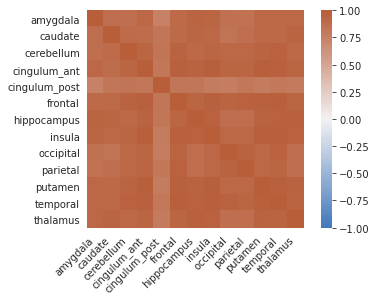

In [16]:
ax = sns.heatmap(
    corrMatrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(250, 25, n=250),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Things are intercorrelated!

##  4. Statistics

### 4.1 T-test

some studies did a simple t-statistics to compare groups

In [17]:
import pingouin as pg
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [18]:
ttest = pd.DataFrame()
for roi in ROIs:
    tPTSD = data[roi][data['group'] == 1]
    tHC   = data[roi][data['group'] == 0]
    
    t = pg.ttest(tPTSD, tHC, paired=False)
    t['roi'] = roi
    ttest = ttest.append(t)
ttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,roi
T-test,-3.693866,22.797505,two-sided,0.001213,"[-0.54, -0.15]",1.254878,42.216,0.954055,amygdala
T-test,-3.124249,25.291231,two-sided,0.004433,"[-0.36, -0.07]",1.017762,11.568,0.840645,cerebellum
T-test,-3.380102,22.568089,two-sided,0.002629,"[-0.46, -0.11]",1.153140,20.322,0.917761,cingulum_ant
T-test,-3.063617,22.030687,two-sided,0.005682,"[-0.36, -0.07]",1.055848,10.169,0.866004,frontal
T-test,-3.578915,25.887808,two-sided,0.001394,"[-0.48, -0.13]",1.155242,32.141,0.918684,hippocampus
T-test,-3.672190,23.561625,two-sided,0.001228,"[-0.5, -0.14]",1.230699,40.084,0.946880,insula
T-test,-3.337010,22.190141,two-sided,0.002963,"[-0.37, -0.09]",1.146558,18.442,0.914822,occipital
T-test,-3.285603,21.654088,two-sided,0.003426,"[-0.39, -0.09]",1.140740,16.444,0.912159,parietal
T-test,-3.656118,23.996513,two-sided,0.001250,"[-0.44, -0.12]",1.216254,38.578,0.942186,temporal



A strong significant effect for group in a simple t statistics.

The high inter-correlation between regions can explain why it is significant across regions.

We can try to introduce age as a covariate to see how influential age is in the analysis

### 4.2 ANCOVA

In [19]:
ANCOVA = pd.DataFrame()
for roi in ROIs:
    acv = pg.ancova(data=data, dv=roi, covar='age', between='group')
    acv['roi'] = roi
    ANCOVA = ANCOVA.append(acv)
    
ANCOVA[ANCOVA['Source']=='group']

,Source,SS,DF,F,p-unc,np2,roi
0,group,0.481061,1,6.626204,0.014071,0.148482,amygdala
0,group,0.139998,1,3.247062,0.079489,0.078722,cerebellum
0,group,0.328638,1,5.576088,0.023437,0.127962,cingulum_ant
0,group,0.189546,1,4.546206,0.039515,0.106853,frontal
0,group,0.358015,1,5.333864,0.026445,0.123088,hippocampus
0,group,0.409595,1,6.307738,0.016391,0.142362,insula
0,group,0.270613,1,6.622197,0.014098,0.148406,occipital
0,group,0.227170,1,5.382267,0.025812,0.124066,parietal
0,group,0.357437,1,6.863564,0.012573,0.152987,temporal



Controlling for age most regions still remain significant. Interestingly, age does not seem to be significant.

Previous studies suggest a sex effect on CB1, thou plotting of our data, doesn't seem to be affected by it.


In [20]:
ANCOVA_s = pd.DataFrame()
for roi in ROIs:
    acv = pg.ancova(data=data, dv=roi, covar=['age','sex'], between='group')
    acv['roi'] = roi
    ANCOVA_s = ANCOVA_s.append(acv)
    
ANCOVA_s[ANCOVA_s['Source']=='group']

,Source,SS,DF,F,p-unc,np2,roi
0,group,0.560966,1,7.753734,0.008398,0.173253,amygdala
0,group,0.176971,1,4.102350,0.050082,0.099808,cerebellum
0,group,0.376812,1,6.363466,0.016080,0.146747,cingulum_ant
0,group,0.220851,1,5.264198,0.027542,0.124555,frontal
0,group,0.491382,1,7.645599,0.008824,0.171251,hippocampus
0,group,0.477312,1,7.364189,0.010043,0.165994,insula
0,group,0.257668,1,6.148728,0.017829,0.142501,occipital
0,group,0.260286,1,6.132430,0.017970,0.142177,parietal
0,group,0.403023,1,7.713160,0.008555,0.172503,temporal



Effects seem to be stronger but no real difference.

Using OLS regression I calculated AIC to see with model better represent the data 


In [21]:
AIC = pd.DataFrame()
for roi in ROIs:
    m1 = smf.ols(formula='Vt ~ 1 + group', data=data_long[data_long['ROI']==roi])
    m2 = smf.ols(formula='Vt ~ 1 + group + age', data=data_long[data_long['ROI']==roi])
    m3 = smf.ols(formula='Vt ~ 1 + group + age + sex', data=data_long[data_long['ROI']==roi])
    
    m1f = m1.fit()
    m2f = m2.fit()
    m3f = m3.fit()
    temp = {'roi': roi, 'M1':m1f.aic, 'M2': m2f.aic, 'M3': m3f.aic}
    AIC = AIC.append(temp, ignore_index=True)
AIC

,roi,M1,M2,M3
0,amygdala,12.193668,11.702993,12.467080
1,cerebellum,-7.825381,-9.661577,-8.732399
2,cingulum_ant,3.192207,3.154875,4.254296
3,frontal,-11.192634,-11.036550,-9.874930
4,hippocampus,8.982373,8.486000,7.612953
5,insula,7.606930,7.128643,7.959363
6,occipital,-13.138926,-11.859613,-9.921322
7,parietal,-10.430985,-10.534321,-9.397986
8,temporal,-2.512753,-1.918435,-0.875117



At least for the Amygdala it seems that the group + age analysis fits best to the data

### 4.3 Correlations

I want to check if the correlation between age and Vt is significant (no group)


In [22]:
cor = pd.DataFrame()
for roi in ROIs:
    rcor = pg.corr(data.age, data[roi], method='bicor')
    rcor['roi'] = roi
    cor = cor.append(rcor)
    
cor

,n,r,CI95%,p-val,power,roi
bicor,41,-0.432193,"[-0.65, -0.14]",0.004774,0.821649,amygdala
bicor,41,-0.457610,"[-0.67, -0.17]",0.002628,0.868431,cerebellum
bicor,41,-0.374530,"[-0.61, -0.08]",0.015842,0.688802,cingulum_ant
bicor,41,-0.369365,"[-0.61, -0.07]",0.017469,0.675486,frontal
bicor,41,-0.409923,"[-0.64, -0.12]",0.007774,0.774297,hippocampus
bicor,41,-0.418482,"[-0.64, -0.13]",0.006470,0.793157,insula
bicor,41,-0.333782,"[-0.58, -0.03]",0.032946,0.580068,occipital
bicor,41,-0.405568,"[-0.63, -0.11]",0.008520,0.764405,parietal
bicor,41,-0.396621,"[-0.63, -0.1]",0.010248,0.743485,temporal



They are all correlated.

Let's move to correlation between Vt and PTSD symptoms.

In [23]:
cor = pd.DataFrame()
for roi in ROIs:
    rcor = pg.corr(PTSD.Total, PTSD[roi])
    rcor['roi'] = roi
    cor = cor.append(rcor)
cor

,n,r,CI95%,p-val,BF10,power,roi
pearson,13,0.418979,"[-0.17, 0.79]",0.154154,0.859,0.308181,amygdala
pearson,13,0.235027,"[-0.36, 0.7]",0.439557,0.448,0.121811,cerebellum
pearson,13,0.183556,"[-0.41, 0.67]",0.548326,0.402,0.092237,cingulum_ant
pearson,13,0.221024,"[-0.38, 0.69]",0.468043,0.434,0.112899,frontal
pearson,13,0.311477,"[-0.29, 0.74]",0.300225,0.556,0.182903,hippocampus
pearson,13,0.259865,"[-0.34, 0.71]",0.391212,0.477,0.139297,insula
pearson,13,0.041097,"[-0.52, 0.58]",0.893954,0.344,0.051046,occipital
pearson,13,0.102082,"[-0.48, 0.62]",0.740008,0.359,0.061943,parietal
pearson,13,0.227789,"[-0.37, 0.69]",0.454174,0.44,0.117122,temporal



No correlation between brain and behavior. Can it be explained by a strong "global signal"?

Next, I ran a partial correlation without the global signal.


In [24]:
pcor = pd.DataFrame()
PTSD['glob_sig'] = PTSD[['amygdala', 'caudate', 'cerebellum', 'cingulum_ant', 'cingulum_post', 'frontal', 'hippocampus', 'insula', 'occipital', 'parietal', 'putamen', 'temporal', 'thalamus']].mean(axis = 1) 
for roi in ROIs:
    try:
        rcor = pg.partial_corr(data=PTSD, x='Total', y=roi, covar='glob_sig').round(3)
        rcor['roi'] = roi
        pcor = pcor.append(rcor)
    except:
        print('skip')
pcor

,n,r,CI95%,p-val,roi
pearson,13,0.611,"[0.06, 0.88]",0.035,amygdala
pearson,13,0.050,"[-0.54, 0.61]",0.878,cerebellum
pearson,13,-0.170,"[-0.68, 0.45]",0.598,cingulum_ant
pearson,13,-0.033,"[-0.6, 0.55]",0.919,frontal
pearson,13,0.392,"[-0.23, 0.79]",0.207,hippocampus
pearson,13,0.201,"[-0.42, 0.69]",0.531,insula
pearson,13,-0.432,"[-0.81, 0.19]",0.161,occipital
pearson,13,-0.279,"[-0.74, 0.35]",0.380,parietal
pearson,13,0.014,"[-0.56, 0.58]",0.965,temporal



A positive correlation between Symptoms and the ratio of CB1r in the Amygdala to the rest of the brain.

The higher the ratio of CB1r in the Amygdala to CB1r in the rest of the brain, the worst the symptoms (CAPS score).


<AxesSubplot:xlabel='Amygdala', ylabel='TotslSymp'>

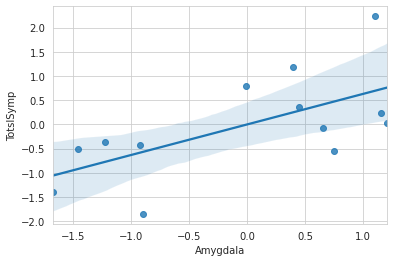

In [25]:
X = PTSD[['glob_sig']]   # independent variables
y = PTSD['amygdala']   # dependent variables

# to get intercept -- this is optional
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['Amygdala'] = influence.resid_studentized_internal

X = PTSD[[ 'glob_sig']]   # independent variables
y = PTSD['Total']   # dependent variables

# to get intercept -- this is optional
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit() 
influence = model.get_influence()

PTSD['TotslSymp'] = influence.resid_studentized_internal

sns.regplot(x = 'Amygdala', y = 'TotslSymp', data = PTSD)


Is this correlation driven by re-experiencing symptoms?


In [26]:
Bpcor = pd.DataFrame()
PTSD['glob_sig'] = PTSD[['amygdala', 'caudate', 'cerebellum', 'cingulum_ant', 'cingulum_post', 'frontal', 'hippocampus', 'insula', 'occipital', 'parietal', 'putamen', 'temporal', 'thalamus']].mean(axis = 1) 
for roi in ROIs:
    try:
        rcor = pg.partial_corr(data=PTSD, x='B', y=roi, covar='glob_sig').round(3)
        rcor['roi'] = roi
        Bpcor = Bpcor.append(rcor)
    except:
        print('skip')
Bpcor

,n,r,CI95%,p-val,roi
pearson,13,0.445,"[-0.17, 0.81]",0.147,amygdala
pearson,13,-0.025,"[-0.59, 0.56]",0.939,cerebellum
pearson,13,0.060,"[-0.53, 0.61]",0.854,cingulum_ant
pearson,13,-0.097,"[-0.64, 0.5]",0.764,frontal
pearson,13,0.117,"[-0.49, 0.65]",0.718,hippocampus
pearson,13,0.369,"[-0.26, 0.78]",0.238,insula
pearson,13,-0.344,"[-0.77, 0.29]",0.274,occipital
pearson,13,0.099,"[-0.5, 0.64]",0.760,parietal
pearson,13,-0.282,"[-0.74, 0.35]",0.374,temporal


Doesn't seem like it...